# Supervised Learning
This notebook demonstrates a variety of supervised learning approaches--from simple linear regression to random forests.

If you are interested in learning from data, specifically labelled data, then this notebook will help guide you through learning from data with Python. We'll use some key Python statistics and machine learning libaries:

* `sci-kit learn`
* `statsmodels`

We'll use basic information about baseball players such as height, weight, and handedness to try to predict average runs scored per season. This could be used in player recruiting models (e.g. "moneyball"). 

The data we will use comes from [Sean Lahman](http://www.seanlahman.com/baseball-archive/statistics/). He has provided a [data dictionary](http://www.seanlahman.com/files/database/readme2017.txt) as well, which is critical for understanding the data sources.

Let's get started by importing some packages we'll need:

In [48]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score
%matplotlib inline

### Loading our data

Next, let's load the Lahman players data and batting data. Note that these are two separate `.csv` files. The first we'll load as a dataframe called `players` and the second as a dataframe called `batting`. 

In [24]:
players = pd.read_csv('data/People.csv')
batting = pd.read_csv('data/Batting.csv')

In [25]:
print("There are {0} players in the dataset.".format(players.shape[0]))
print("There are {0} batting records in the dataset.".format(batting.shape[0]))

There are 19370 players in the dataset.
There are 104324 batting records in the dataset.


Note that there are far more batting records than there are players. That is because each batting record corresponds to a specific player _in a specific year_. We can handle this by calculating the average runs per season per player. This will give us a sense as to how the player generally does overall, instead of in any specific year.

In [26]:
avg_runs = pd.DataFrame(batting.groupby(['playerID']).R.mean())

Let's check on a player we recognize. I know that `harperbr03` is the `playerID` for Bryce Harper of the Washington Nationals. Let's take a look at his average runs (per season):

In [27]:
avg_runs.loc['harpebr03']

R    84.5
Name: harpebr03, dtype: float64

### Merging player data with batting data
Now, let's join the two datasets. We want to know, for each player, what were his average runs per season as well as his vital stats. So let's do a left join:

In [28]:
df = players.set_index('playerID').join(avg_runs, how='left')

Let's focus on just players who actually have scored runs:

In [29]:
df = df[df['R'] > 0]

In [30]:
print("There are {0} players who scored runs.".format(df.shape[0]))

There are 13596 players who scored runs.


### Generating dummy variables
We can't just feed algorithms categorical information such as handedness. How will our model understand the difference between "left hand" and "right hand"? To get around this we can create dummy variables.

Dummy variables take each of the categories and convert it into its own column with binary values. So a right handed player would have values `1` for the `right_handed` column and `0` for the `left_handed` column. That's something we can work with! So, let's generate dummy variables for whether the player bats and throws righthanded, lefthanded, or both.

In [31]:
bats_dummies = pd.get_dummies(df.bats, prefix='bats')
throws_dummies = pd.get_dummies(df.throws, prefix='throws')

Now we need to add these dummy variable columns to our dataframe:

In [32]:
df = df.join(bats_dummies)
df = df.join(throws_dummies)

### Assessing average runs
Before we get started learning from data, let's try to understand a typical player's performance. We can use a kernel density estimation plot on average runs to get a sense for the distribution of runs we can expect from players:

(0, 193.91677018633538)

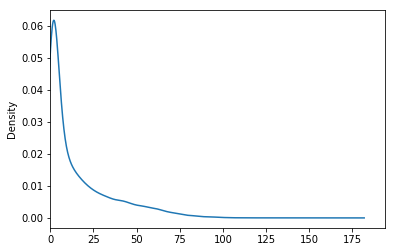

In [61]:
plot = df['R'].plot(kind='kde')
plot.set_xlim(0,)

We can see that this looks like a log-normal distribution. This makes sense and is actually the case for many natural phenomenon. Consider height, for example, there is a natural limit to the height a person can grow to so density at its higher bounds is very small. 

We can check this by looking at the distribution of `log(runs)`.

In [65]:
df['R_log'] = np.log(df.R)

(0, 9.557392426547839)

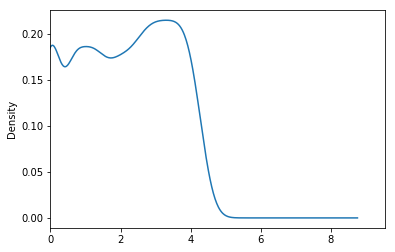

In [66]:
plot = df['R_log'].plot(kind='kde')
plot.set_xlim(0,)

It does look more "normal" (though not perfectly so). I most cases, we would want to identify the functional form of the distribution and convert it to a normal (or gaussian) distribution prior to learning from it. However, that complicates interpretation of our data so we will continue using the non-transformed variables.

In [67]:
total_median_runs = df['R'].median()
print("On average, players we're considering scored {0} runs per season.".format(round(total_median_runs,2)))

On average, players we're considering scored 6.21 runs per season.


### Regression

Let's focus just on the features we think will be predictive of runs:

- birth month
- weight
- height
- batting hand
- throwing hand

We can subset our data to reflect these features of interest. We can also set our X (explanatory variable) and y (response variables).

In [68]:
df = df.reset_index()
df = df[['birthMonth','weight','height','bats_B','bats_L','bats_R','throws_L','throws_R', 'R']].dropna()
X = df[['birthMonth','weight','height','bats_B','bats_L','bats_R','throws_L','throws_R']]
y = df['R']

Now let's split our data into training and test sets. We will specify that 20% of that data should be held back for testing purposes:

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Next, we can fit the ordinary least squares regression model to our data:

In [72]:
results = sm.OLS(y_train, X_train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      R   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     878.0
Date:                Tue, 07 Aug 2018   Prob (F-statistic):               0.00
Time:                        11:48:41   Log-Likelihood:                -45472.
No. Observations:               10420   AIC:                         9.096e+04
Df Residuals:                   10412   BIC:                         9.102e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
birthMonth     0.0251      0.054      0.468      0.6

We can see that a non-trivial amount of variance (40%) is explained by our model. This isn't overwhelming, to say the least, but we also learned that the majority of our features have some bearing on average runs as well. It seems that being able to bat with your left hand (or both hands) is associated with a significant increase in runs. 

#### Generating predictions
Remember the 20% of data we held back for testing purposes. Now we get to use it! We can generate predictions on our test data and score the results:

In [73]:
preds = results.predict(X_test)

We can evaluate our model's performance by calculating the Mean Absolute Error (MAE) using `sci-kit learn`:

In [74]:
mean_absolute_error(y_test, preds)

14.787763543688797

Or we can calculate it ourself if we'd like:

In [75]:
sum(abs(preds - y_test))/len(y_test)

14.787763543688843

### Classification
To perform classification, we need to convert runs, which is a continuous variable, into a categorical or dichotomous variable. To do this, we want to categorize a certain number of runs as _good_ and anything below that as _bad_.

We'll use the median runs as a cutoff point. Anything above the median should be considered _good_ (or a `1`) and anything below _bad_ (a `0`). This way we can use classification algorithms to determine whether we expect a given player, based on his stats, to be a good or bad scorer.

In [76]:
def above_avg(runs, median):
    if runs > median:
        return 1
    else:
        return 0

df['R_'] = df['R'].apply(lambda x: above_avg(x, total_median_runs))

Note that we have to swap our y variable for this new binary variable called `R_`:

In [77]:
X = df[['birthMonth','weight','height','bats_B','bats_L','bats_R','throws_L','throws_R']]
y = df['R_']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Naive Bayes
Now we can begin running classifiers on this data. We can start with Naive Bayes:

In [78]:
nb = MultinomialNB()
start_time = time.time()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
end_time = time.time()
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
print('Accuracy: {}'.format(round(acc, 3)))
print('Precision: {}'.format(round(pre, 3)))
print('Recall: {}'.format(round(rec, 3)))
print('{} seconds'.format(round(end_time - start_time, 3)))

Accuracy: 0.574
Precision: 0.574
Recall: 0.512
0.005 seconds


#### Logistic Regression

In [259]:
logreg = LogisticRegression()
start_time = time.time()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
end_time = time.time()
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
print('Accuracy: {}'.format(round(acc, 3)))
print('Precision: {}'.format(round(pre, 3)))
print('Recall: {}'.format(round(rec, 3)))
print('{} seconds'.format(round(end_time - start_time, 3)))

Accuracy: 0.626
Precision: 0.642
Recall: 0.582
0.045 seconds


#### Support Vector Machine (SVM)

In [79]:
svmclf = LinearSVC()
start_time = time.time()
svmclf.fit(X_train, y_train)
y_pred = svmclf.predict(X_test)
end_time = time.time()
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
print('Accuracy: {}'.format(round(acc, 3)))
print('Precision: {}'.format(round(pre, 3)))
print('Recall: {}'.format(round(rec, 3)))
print('{} seconds'.format(round(end_time - start_time, 3)))

Accuracy: 0.51
Precision: 0.0
Recall: 0.0
0.488 seconds


/Users/brandon/anaconda/envs/ddl/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Random Forest

In [80]:
rfclf = RandomForestClassifier(n_estimators=100)
start_time = time.time()
rfclf.fit(X_train, y_train)
y_pred = rfclf.predict(X_test)
end_time = time.time()
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
print('Accuracy: {}'.format(round(acc, 3)))
print('Precision: {}'.format(round(pre, 3)))
print('Recall: {}'.format(round(rec, 3)))
print('{} seconds'.format(round(end_time - start_time, 3)))

Accuracy: 0.553
Precision: 0.542
Recall: 0.56
0.79 seconds


One of the benefits of random forests is that we can determine the relative importance of each feature:

In [81]:
features = [col for col in X_train]

feature_imp = pd.DataFrame({'feature':features, 'importance':rfclf.feature_importances_}) \
                .sort_values(by='importance', ascending = False)
feature_imp.head(10)

,feature,importance
1,weight,0.479137
0,birthMonth,0.256280
2,height,0.195891
5,bats_R,0.019234
7,throws_R,0.013920
6,throws_L,0.013601
4,bats_L,0.013293
3,bats_B,0.008642
